[View in Colaboratory](https://colab.research.google.com/github/sungreong/TIL/blob/master/word2vec_and_doc2vec_(1).ipynb)

## 참고
https://github.com/hoho0443/classify_comment_emotion/blob/master/doc2vec_train.py  
https://datascienceschool.net/view-notebook/6927b0906f884a67b0da9310d3a581ee/  
https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-2.ipynb

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/GPU")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
annotations	    drive   images	    jpype-master  __pycache__
annotations.tar.gz  filter  images.tar.gz   model_save	  torch_gan
data		    graphs  imFunctions.py  output


In [0]:
!apt-get update

!apt-get install g++ openjdk-8-jdk python-dev python3-dev

In [0]:
os.chdir("./jpype-master")
!ls

In [0]:
!python setup.py build
!python setup.py install

In [0]:
!pip install -q keras

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import *
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from nltk.tokenize import sent_tokenize
from konlpy.corpus import kolaw
from konlpy.tag import Twitter
import numpy as np

Using TensorFlow backend.


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import codecs

def read_data(filename):
    with codecs.open(filename, encoding='utf-8', mode='r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

!ls

annotations	    drive   images	    jpype-master  __pycache__
annotations.tar.gz  filter  images.tar.gz   model_save	  torch_gan
data		    graphs  imFunctions.py  output


In [0]:
train_data = read_data("./data/nlp/ratings_train.txt")

In [6]:
print(train_data[0:10])

len(train_data)

[['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0'], ['3819312', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1'], ['10265843', '너무재밓었다그래서보는것을추천한다', '0'], ['9045019', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '0'], ['6483659', '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다', '1'], ['5403919', '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.', '0'], ['7797314', '원작의 긴장감을 제대로 살려내지못했다.', '0'], ['9443947', '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네', '0'], ['7156791', '액션이 없는데도 재미 있는 몇안되는 영화', '1'], ['5912145', '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?', '1']]


150000

In [7]:
from konlpy.tag import Twitter
tagger = Twitter()

tagger.nouns(train_data[0][1])
tagger.pos(train_data[0][1], norm=True, stem=True)

[('아', 'Exclamation'),
 ('더빙', 'Noun'),
 ('..', 'Punctuation'),
 ('진짜', 'Noun'),
 ('짜증', 'Noun'),
 ('나다', 'Verb'),
 ('목소리', 'Noun')]

In [0]:
def tokenize(doc) : 
    return ["/".join(t) for t in tagger.pos(doc, norm=True, stem=True)]

train_docs = [ row[1] for row in train_data]
sentences = [tokenize(d) for d in train_docs]

In [0]:
!pip install gensim

In [0]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

In [0]:
from gensim.models import word2vec
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

In [42]:

model.similarity(*tokenize(u'악당 영웅'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


0.6102890797088961

In [11]:
model.wv.most_similar(*tokenize(u'악당'))

[('경찰/Noun', 0.7794839143753052),
 ('외계인/Noun', 0.7478086948394775),
 ('싸움/Noun', 0.7331266403198242),
 ('킬러/Noun', 0.7138746976852417),
 ('형사/Noun', 0.707720160484314),
 ('캐릭/Noun', 0.7033036947250366),
 ('살인마/Noun', 0.7003135085105896),
 ('부인/Noun', 0.6909421682357788),
 ('총/Noun', 0.6889263391494751),
 ('선생/Noun', 0.6881362795829773)]

In [15]:
model.similarity(*tokenize(u'악당 감동'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.0589507932372569

In [16]:
from konlpy.utils import pprint
pprint(model.most_similar(positive=tokenize(u'여배우 남자'), negative=tokenize(u'배우'), topn=1))

[('여자/Noun', 0.8148828744888306)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [44]:
model.wv.doesnt_match(tokenize(u'여배우 남자 배우'))

'남자/Noun'

In [0]:
model_name = './model_save/word2vec'
# model_name = '300features_50minwords_20text'
model.save(model_name)

In [13]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = './model_save/word2vec'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


3927
[-0.03677921  0.02346137 -0.01355425 -0.03602938 -0.02026409  0.09161764
  0.05691804 -0.02518279  0.0828283   0.0539264 ]


In [14]:
import pandas as pd
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [50]:
df.head(10)

,x,y
아/Exclamation,14.816881,29.899429
더빙/Noun,11.019031,3.802800
../Punctuation,-89.158943,69.251656
진짜/Noun,-1.962214,21.479927
짜증/Noun,19.763008,24.372385
나다/Verb,6.241718,33.760864
목소리/Noun,-1.233049,0.871116
흠/Noun,15.230837,-10.949785
.../Punctuation,14.356312,-27.482061
포스터/Noun,14.640639,9.618922


In [0]:
!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv




In [0]:
%%bash
cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/

In [0]:
!rm -rf  /content/.cache/matplotlib
import matplotlib
import matplotlib.font_manager
matplotlib.font_manager.list_fonts('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/', '*')

In [0]:
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=path, size=10)

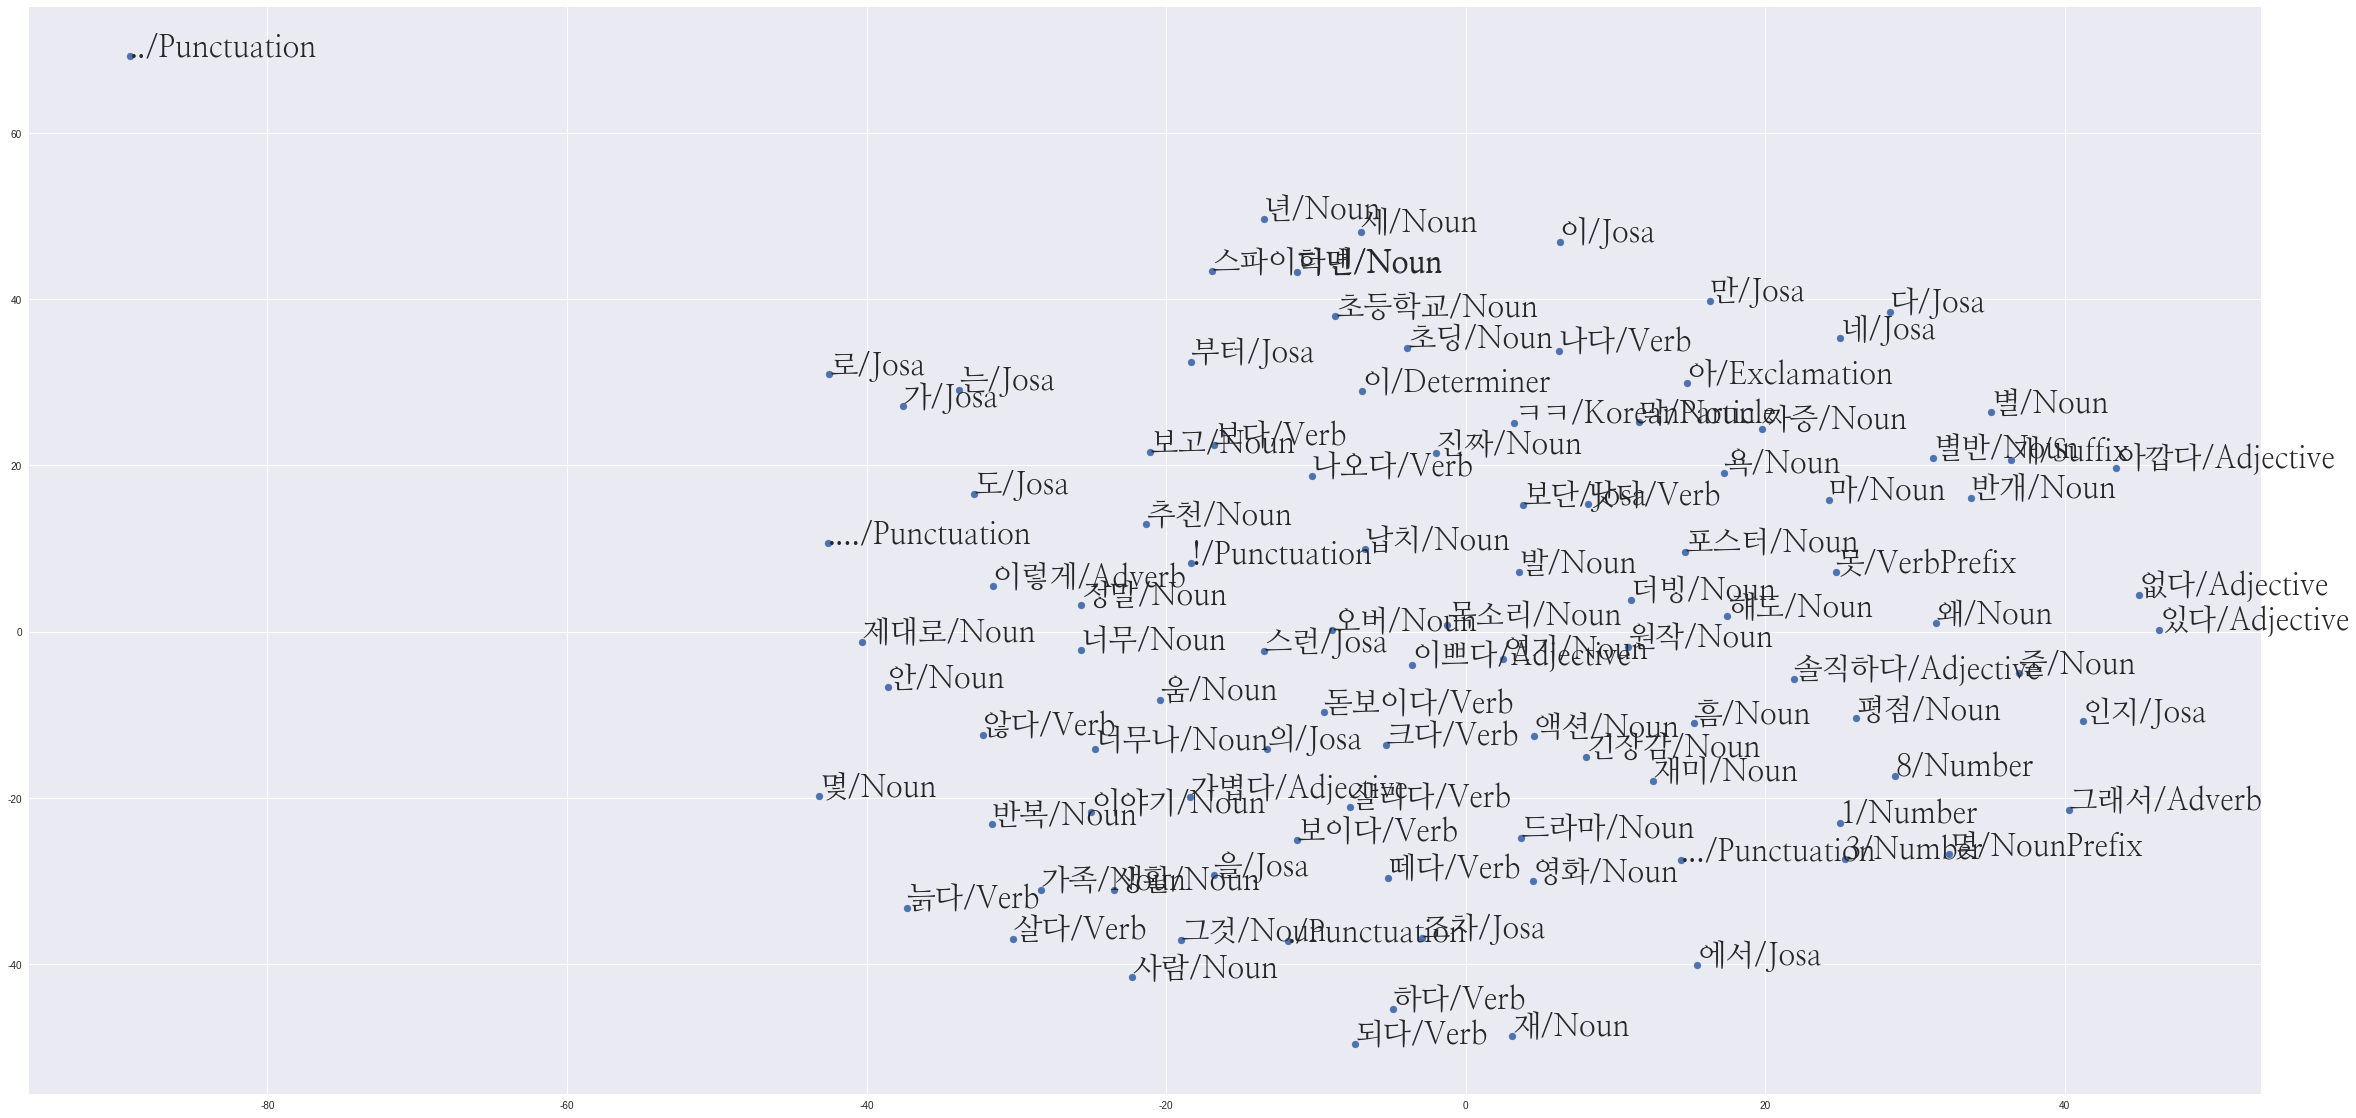

In [59]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30,fontproperties=fontprop)
plt.show()

In [0]:
train_data = read_data("./data/nlp/ratings_train.txt")
train_docs = [(tokenize(row[1]), row[2]) for row in train_data[1:]]


In [0]:
from collections import namedtuple
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]

In [17]:
from gensim.models import doc2vec
doc_vectorizer = doc2vec.Doc2Vec(size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [18]:
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.iter)
    doc_vectorizer.alpha -= 0.002  # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # fix the learning rate, no decay

#To save
doc_vectorizer.save('./model_save/doc2vec.model')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [19]:
pprint(doc_vectorizer.most_similar('공포/Noun'))


Pretty printing has been turned OFF


In [20]:
pprint(doc_vectorizer.similarity('공포/Noun', 'ㅋㅋ/KoreanParticle'))

Pretty printing has been turned ON


In [0]:
test_data = read_data("./data/nlp/ratings_test.txt")
test_docs = [(tokenize(row[1]), row[2]) for row in test_data[1:]]

In [0]:
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [0]:
from gensim.models import Doc2Vec
doc_vectorizer = Doc2Vec.load('./model_save/doc2vec.model')

In [0]:
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]


```
classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1,   

                                        penalty='l2', random_state=None, tol=0.0001)
```


In [28]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
import pickle
print( classifier.score(test_x, test_y) )
# 0.63904

# save the model to disk
filename = './model_save/finalized_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

0.6370127402548051


In [0]:
run_data = read_data("./data/nlp/ratings_run.txt")
run_docs = [(tokenize(row[1]), row[2]) for row in run_data[1:]]

In [0]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_run_docs = [TaggedDocument(d, [c]) for d, c in run_docs]

In [0]:
doc_vectorizer = Doc2Vec.load('./model_save/doc2vec.model')

# 분류를 위한 피쳐 생성
run_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_run_docs]
run_y = [doc.tags[0] for doc in tagged_run_docs]

In [35]:
# load the model from disk
filename = './model_save/finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model.predict(run_x[0].reshape(1, -1)))
print(loaded_model.predict(run_x[1].reshape(1, -1)))

['1']
['1']


array([-4.35536029e-03, -3.50129008e-02,  1.86314192e-02,  8.47670585e-02,
        1.44093484e-01, -4.03449312e-02,  4.82706986e-02, -5.74399456e-02,
        9.54083130e-02, -1.76338684e-02, -7.23009631e-02,  8.45829956e-03,
        7.40080476e-02, -1.68110151e-03,  3.97836305e-02,  6.49952516e-02,
        3.00768279e-02, -6.60729501e-03, -4.53816615e-02,  2.34892368e-02,
       -8.04238170e-02, -3.84260975e-02, -1.43008217e-01, -9.17795971e-02,
       -1.05017737e-01, -7.72589967e-02,  3.39792557e-02, -7.98784047e-02,
       -5.32962270e-02, -1.82392239e-03, -6.85528293e-02, -5.97225390e-02,
       -4.16147448e-02, -7.70665780e-02, -8.96852165e-02,  7.01255873e-02,
        2.24662870e-01,  5.61784692e-02,  9.05539989e-02,  1.19822705e-02,
       -1.69990525e-01,  1.83704332e-01, -3.46106924e-02,  2.16734901e-01,
        2.34729704e-02, -1.49454683e-01,  2.01173080e-03,  4.56030145e-02,
        2.81285830e-02, -1.75587218e-02,  7.06785396e-02,  2.71490067e-02,
       -2.93267090e-02,  